In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [2]:
def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    for i in range(start,start+nbins):#no. of toy bins
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f #fraction of signal in prmpt peak
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['sigma'])
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:04d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
    return diagnostics_df, sigma_df, summary

def fit_bin(nsamples,binnr): #fit only one bin
    #read data
    df=pd.read_csv(f"toybins/toybin{binnr:04d}.txt",sep="\t")
    df.columns=['pol','phi','weight']
    #these are prompt peak events
    prmpt=df.loc[df['weight']==1]
    prmpt=prmpt.reset_index(drop=True)
    #sideband
    side=df.loc[df['weight']!=1]
    side=side.reset_index(drop=True)
    nprmpt=len(prmpt)
    total_nside=(len(side))
    #weights used in the data, including 1--> exterminate 1
    weights=pd.unique(df['weight'].values)
    weights=np.array(weights[weights!=1])
    #sideband events are identified by the corresponding weights
    nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
    #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
    f=(nprmpt+np.sum(nside*weights))/nprmpt
    print(f)
    stan_data={
        'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
        'phi_prmpt':list(prmpt['phi'].values),
        'pol_prmpt':list(prmpt['pol'].values),
        'M':total_nside,#no. of sideband events and..
        'phi_side':list(side['phi'].values),
        'pol_side':list(side['pol'].values),
        'f':f #fraction of signal in prmpt peak
    }
    print(nprmpt, total_nside)
    #now the stan model and mcmc
    model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
    model.compile()
    fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
    summary=fitobj.summary()
    samples=fitobj.draws_pd()
    return samples,summary

In [3]:
dfs=fit(nsamples=1000,nbins=10,start=0)
diagnostics=dfs[0]
sigma=dfs[1]
diagnostics.to_csv('toy_diagnostics.csv')
sigma.to_csv('toy_sigma.csv')

0.9498891625615763
406 313


INFO:cmdstanpy:compiling stan file /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan.stan to exe file /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan
INFO:cmdstanpy:compiled model executable: /Users/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/toyMC_stan
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


0.9500413223140496
363 279


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


0.9499127182044889
401 309


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



0.9499180327868852
427 329


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


0.9497803617571059
387 299


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



0.94984375
416 321


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


0.9500000000000001
403 310


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



0.9498521505376345
372 287


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


0.94984375
416 321


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


0.9499500000000001
400 308


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [12]:
sigma_df=pd.read_csv('toy_sigma.csv',index_col=0)
diagnostics_df=pd.read_csv('toy_diagnostics.csv',index_col=0)

In [18]:
all_sigmas=[]
for i in range(len(sigma_df.columns)):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)))

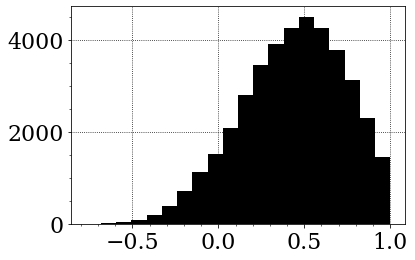

In [19]:
plt.hist(all_sigmas,bins=20)
plt.show()